In [191]:
import pandas as pd
import numpy as np
import os
from pathlib import Path
import sys
from src.modules import conf, fit, spec, evl, pred, preprocess
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
%matplotlib inline
sns.set(style='ticks')
plt.rcParams['figure.figsize'] = [24, 8]
plt.rcParams['figure.dpi']

100.0

In [4]:
data = fit.load_pcls(
        conf["Athlete"]["name"],
        conf["Athlete"]["activity_type"],
        conf["Paths"]["pcl"],
    )

100%|██████████| 361/361 [00:00<00:00, 758.10it/s] 


In [5]:
from src.heuristics import random_shooting
from src.heuristics import genetic_optimization

In [6]:
r_cross = conf['GO']['r_cross']
r_mut = conf['GO']['r_mut']

In [65]:
train_df, test_df = fit.get_train_test_df(data, ratio=0.7)
test_df, valid_df = fit.get_test_valid_df(test_df)
print(len(train_df), len(test_df), len(valid_df))
true_data = valid_df.copy()

182943 103870 6449


In [67]:
del_columns = [x for x in valid_df.columns
               if 'cadence' in x or 'heart_rate' in x or 'enhanced_speed' in x]
valid_df.drop(del_columns,axis=1,inplace=True)

In [68]:
'cadence' in valid_df.columns or 'heart_rate' in valid_df.columns or 'speed' in valid_df.columns

False

In [70]:
best = cols[rmse.index(np.min(rmse))]
best = [x for x in best if 'cadence' not in x and 'heart_rate' not in x and 'speed' not in x]

In [79]:
'cadence' in valid_df.columns or 'heart_rate' in valid_df.columns or 'speed' in valid_df.columns

False

In [141]:
_,_,rmse,cols, nrmse = random_shooting.random_shoot(
                          train_df=train_df,
                          test_df=test_df,
                          hmax=30,
                          endog='heart_rate',
                          ban_cols=['cadence','enhanced_speed','heart_rate']
                          )

100%|██████████| 30/30 [00:29<00:00,  1.01it/s]


In [144]:
np.min(rmse), np.min(nrmse)

(16.1435398471624, 0.11783605727855767)

In [145]:
sorted_cols = [x for _, x in sorted(zip(rmse, cols))]
best, best_eval = genetic_optimization.genetic_algorithm(10, r_cross,r_mut ,sorted_cols,train_df,test_df,train_df.columns,'heart_rate')

 20%|██        | 2/10 [01:19<05:32, 41.57s/it]

New best: 5.562365366692694
New best: 5.555958775475173


 30%|███       | 3/10 [02:09<05:18, 45.56s/it]

New best: 5.37838073770781
New best: 5.281892145332181


 40%|████      | 4/10 [03:02<04:51, 48.56s/it]

New best: 5.141960333192722


 50%|█████     | 5/10 [03:50<04:01, 48.22s/it]

New best: 5.117612211719881
New best: 4.832642973881352


100%|██████████| 10/10 [08:11<00:00, 49.17s/it]


In [146]:
best = cols[rmse.index(np.min(rmse))]
form = random_shooting.get_form(list(best),endog='heart_rate')

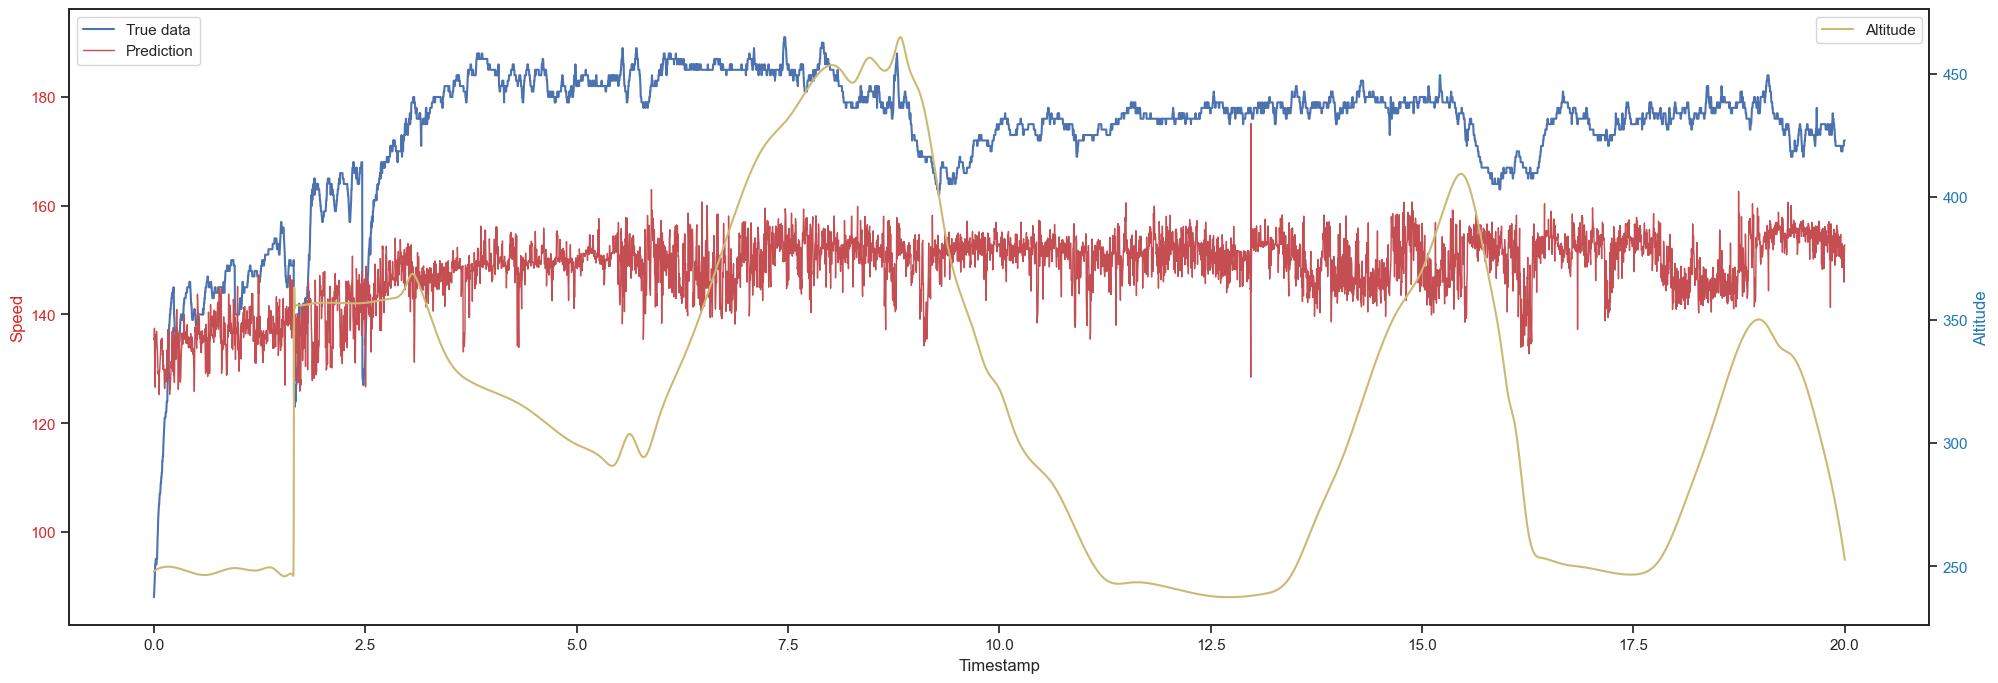

In [147]:
result = spec.ols_form(train_df, form)
pred_ols = pred.predict(valid_df, result)
evl.rmse(true_data.enhanced_speed,pred_ols)
fig = evl.plot(df=true_data,pred=pred_ols,endog='heart_rate', true_data=true_data.heart_rate)

In [158]:
valid_df['heart_rate'] = pred_ols
valid_df['log_heart_rate'] = np.log(pred_ols)
valid_df['sin_heart_rate'] = np.sin(pred_ols)
valid_df['cos_heart_rate'] = np.cos(pred_ols)
valid_df['tan_heart_rate'] = np.tan(pred_ols)
valid_df['diff_heart_rate'] = pred_ols.diff()

In [159]:
_,_,rmse,cols, nrmse = random_shooting.random_shoot(
                          train_df=train_df,
                          test_df=test_df,
                          hmax=30,
                          endog='cadence',
                          ban_cols=['cadence','enhanced_speed']
                          )

100%|██████████| 30/30 [00:24<00:00,  1.21it/s]


In [160]:
np.min(rmse), np.min(nrmse)

(5.559752061141506, 0.060432087621103324)

In [172]:
sorted_cols = [x for _, x in sorted(zip(rmse, cols))]
best, best_eval = genetic_optimization.genetic_algorithm(3, r_cross,r_mut ,sorted_cols,train_df,test_df,train_df.columns,'cadence')

 67%|██████▋   | 2/3 [01:15<00:39, 39.07s/it]

New best: 4.4897610414715095
New best: 2.22298342811644e-13
New best: 7.041229281766445e-14
New best: 5.2985229572940674e-14
New best: 4.38571992755608e-14


100%|██████████| 3/3 [01:55<00:00, 38.42s/it]


In [173]:
best = cols[rmse.index(np.min(rmse))]
form = random_shooting.get_form(list(best), endog='cadence')

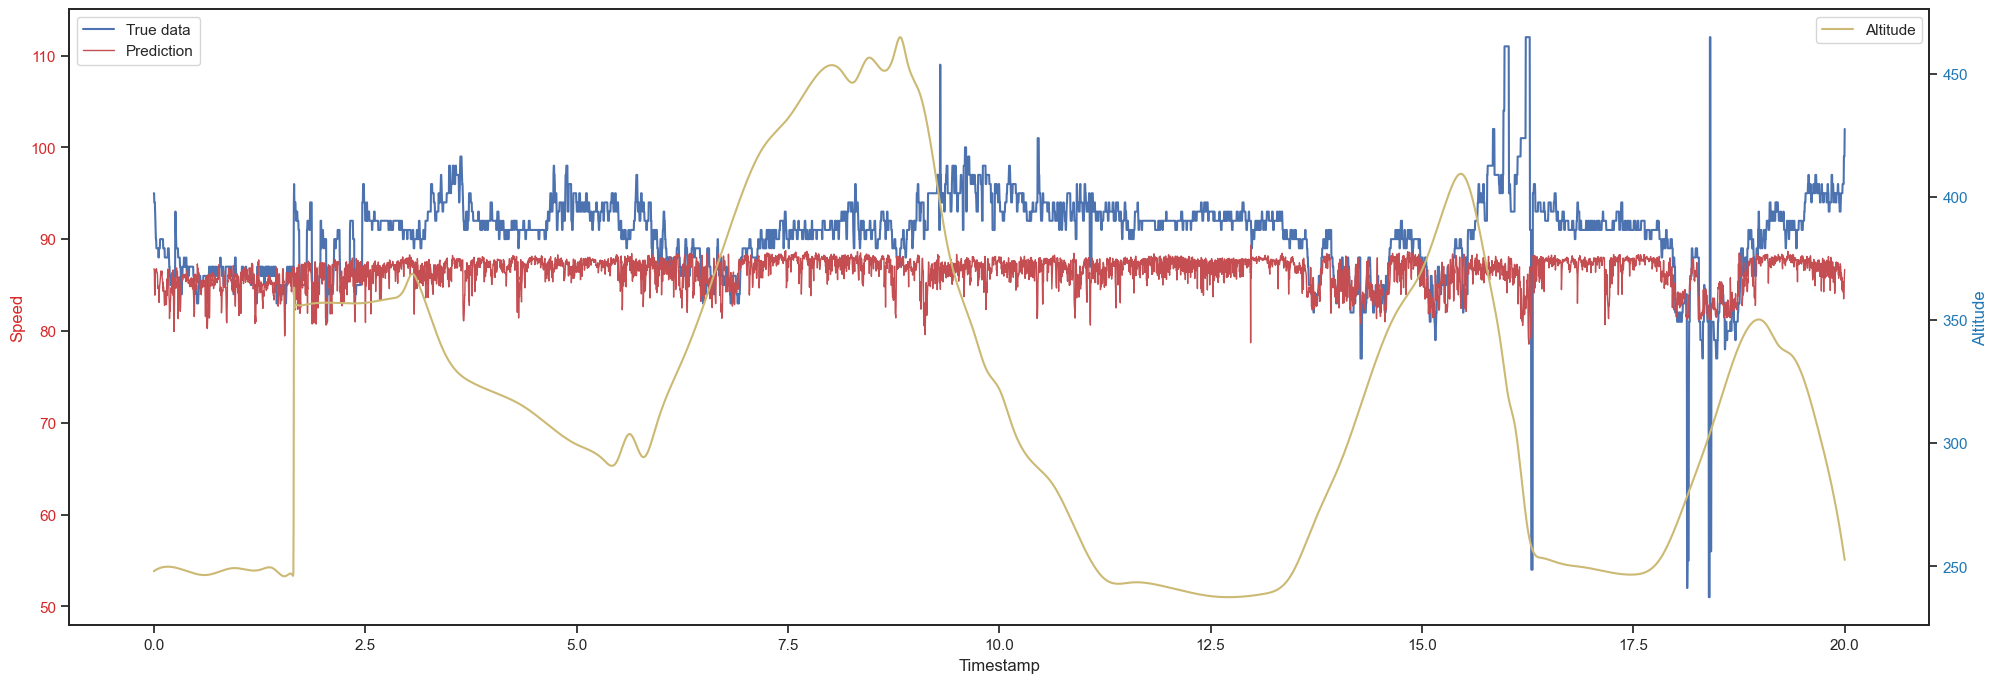

In [178]:
result = spec.ols_form(train_df, form)
pred_ols = pred.predict(valid_df, result)
evl.rmse(true_data.enhanced_speed, pred_ols)
fig = evl.plot(df=true_data, pred=pred_ols, endog='cadence', true_data=true_data.cadence)

In [192]:
valid_df['cadence'] = pred_ols
valid_df['log_cadence'] = np.log(pred_ols)
valid_df['sin_cadence'] = np.sin(pred_ols)
valid_df['cos_cadence'] = np.cos(pred_ols)
valid_df['tan_cadence'] = np.tan(pred_ols)
valid_df['diff_cadence'] = pred_ols.diff()
valid_df['cadence_delayed'] = preprocess.calc_delayed(valid_df.cadence)
valid_df["cadence_delayed"] = [x if x > 1 else 1 for x in valid_df["cadence_delayed"]]

valid_df["log_cadence_delayed"] = np.log(valid_df["cadence_delayed"])
valid_df["diff_cadence_delayed"] = valid_df["cadence_delayed"].diff()
valid_df["sin_cadence_delayed"] = np.sin(valid_df.cadence_delayed)
valid_df["cos_cadence_delayed"] = np.cos(valid_df.cadence_delayed)
valid_df["tan_cadence_delayed"] = np.tan(valid_df.cadence_delayed)

In [184]:
_, _, rmse, cols, nrmse = random_shooting.random_shoot(
    train_df=train_df,
    test_df=test_df,
    hmax=30,
    endog='enhanced_speed',
)

100%|██████████| 30/30 [00:34<00:00,  1.17s/it]


In [185]:
np.min(rmse), np.min(nrmse)

(1.710557052308538, 0.06203064448464382)

In [186]:
sorted_cols = [x for _, x in sorted(zip(rmse, cols))]
best, best_eval = genetic_optimization.genetic_algorithm(3, r_cross, r_mut, sorted_cols, train_df, test_df,
                                                         train_df.columns, 'enhanced_speed')

 67%|██████▋   | 2/3 [01:23<00:42, 42.75s/it]

New best: 1.686335763749176


100%|██████████| 3/3 [02:09<00:00, 43.01s/it]

New best: 1.6833055623766513


In [193]:
best = cols[rmse.index(np.min(rmse))]
form = random_shooting.get_form(list(best), endog='enhanced_speed')

In [198]:
result = spec.ols_form(train_df, form)
pred_ols = pred.predict(valid_df, result)
evl.rmse(true_data.enhanced_speed, pred_ols)

5.874490359677056

In [199]:
for x in range(len(pred_ols)):
    if (pred_ols[x] < 5 or pred_ols[x] > 25):
        pred_ols[x] = np.mean(pred_ols)

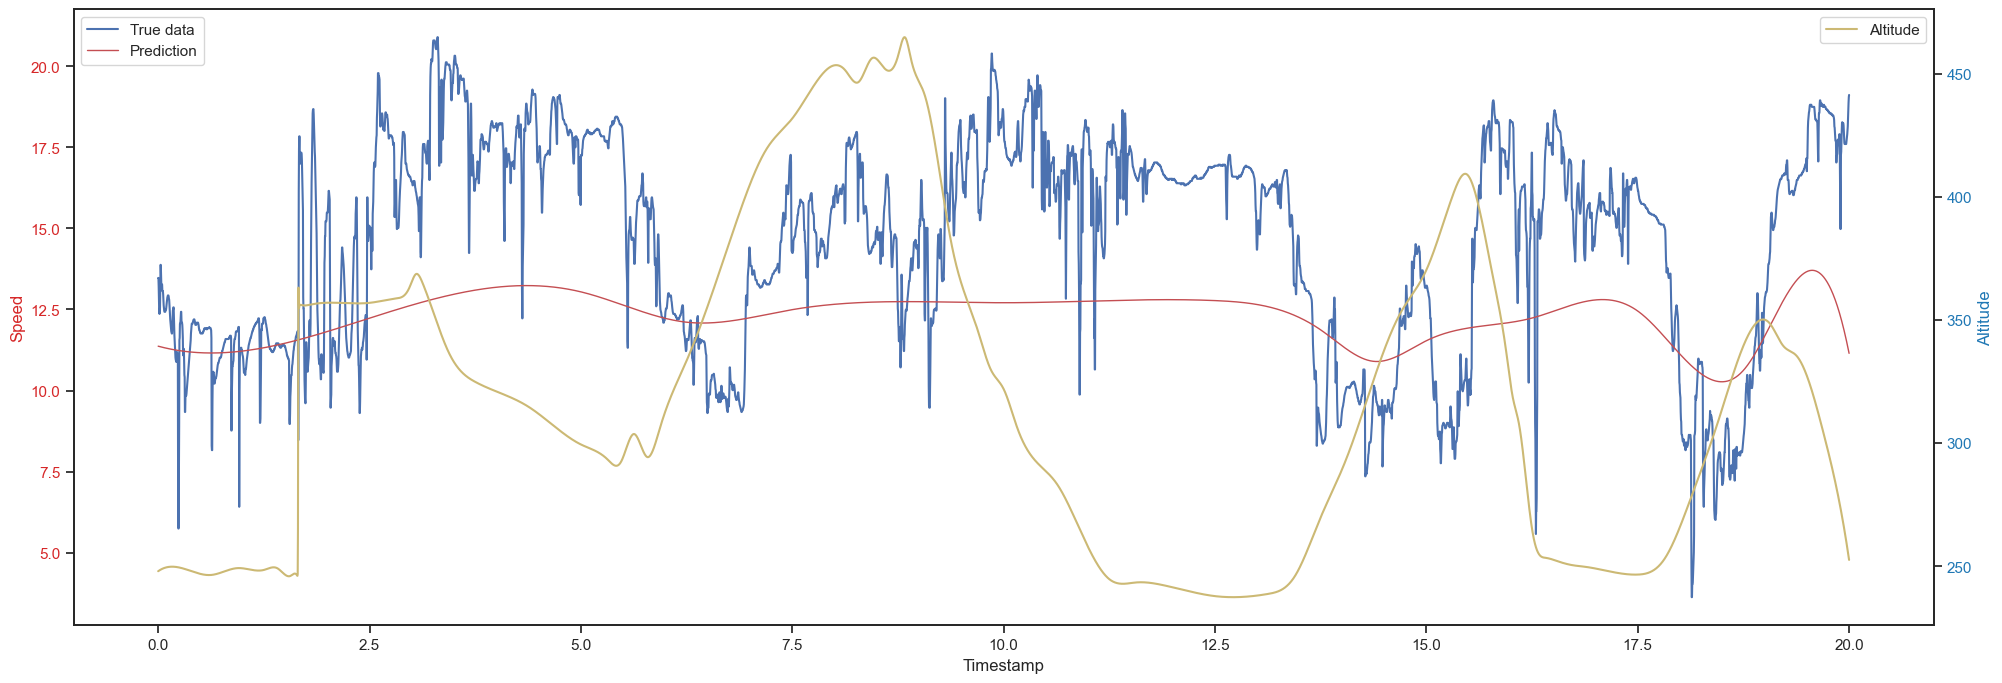

In [202]:
fig = evl.plot(spline=True,df=true_data, pred=pred_ols, endog='enhanced_speed', true_data=true_data.enhanced_speed)

In [201]:
evl.rmse(true_data.enhanced_speed, pred_ols)

3.5034927920955803